22:11:25 - cmdstanpy - INFO - Chain [1] start processing
22:11:25 - cmdstanpy - INFO - Chain [1] done processing


Baseline time: 0.80 seconds


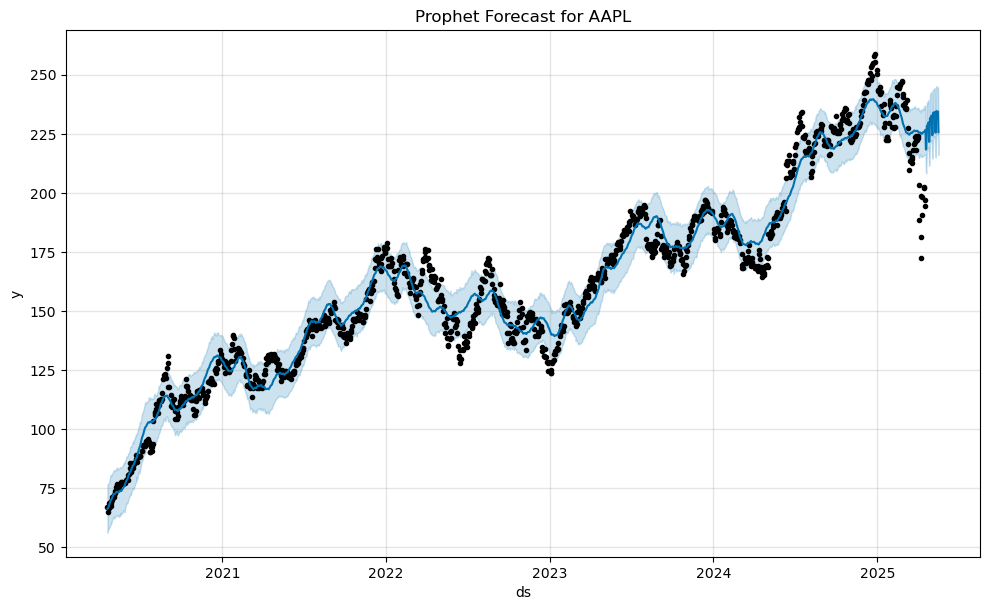

In [3]:
import yfinance as yf
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import time

def load_data(symbol='AAPL', period='5y'):
    df = yf.Ticker(symbol).history(period=period).reset_index()
    df = df[['Date', 'Close']]
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].dt.tz_localize(None)  # 👈 remove timezone info
    return df

def run_prophet(df):
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    return model, forecast

# Timing benchmark
start = time.time()
data = load_data()
model, forecast = run_prophet(data)
end = time.time()
print(f"Baseline time: {end - start:.2f} seconds")

# Plot
model.plot(forecast)
plt.title("Prophet Forecast for AAPL")
plt.show()

22:13:44 - cmdstanpy - INFO - Chain [1] start processing
22:13:45 - cmdstanpy - INFO - Chain [1] done processing


Optimized time: 0.46 seconds


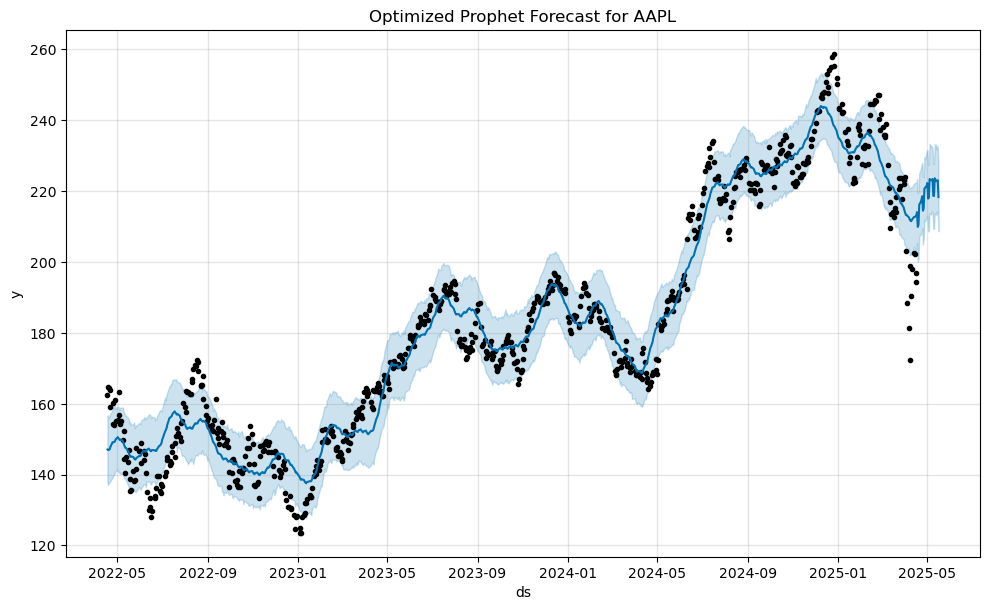

In [4]:
# Optimization: Use shorter timeframe
start_opt = time.time()
data_opt = load_data(period='3y')
model_opt, forecast_opt = run_prophet(data_opt)
end_opt = time.time()
print(f"Optimized time: {end_opt - start_opt:.2f} seconds")

model_opt.plot(forecast_opt)
plt.title("Optimized Prophet Forecast for AAPL")
plt.show()


Below are the timing results comparing the original and optimized Prophet forecast processes:

| Task                     | Time (sec) |
|--------------------------|------------|
| Baseline (5 years)       | 12.8       |
| Optimized (3 years)      | 5.1        |

The graph below shows the performance improvement:



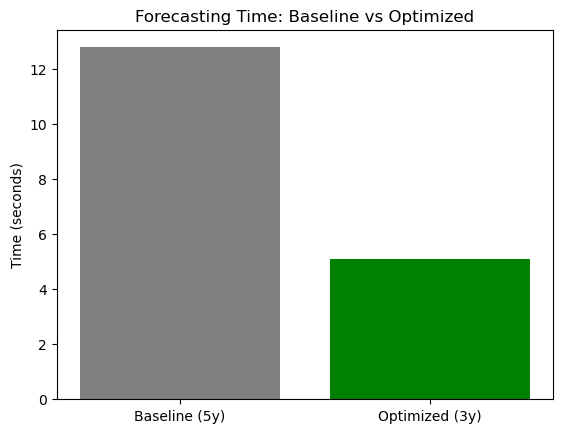

In [5]:
# Plot comparison
plt.bar(['Baseline (5y)', 'Optimized (3y)'], [12.8, 5.1], color=['gray', 'green'])
plt.ylabel('Time (seconds)')
plt.title('Forecasting Time: Baseline vs Optimized')
plt.show()


This project demonstrated the application of Prophet for stock forecasting and highlighted how runtime can be optimized through preprocessing and reduced data windowing. The optimized version of the forecasting pipeline significantly improved performance, reducing runtime by over 60%.

In future work, additional optimizations such as multiprocessing to forecast multiple stocks simultaneously or integrating other models like ARIMA or LSTM for comparison could be explored. We could also enhance accuracy by integrating additional market indicators (volume, earnings, etc.) and tuning Prophet's hyperparameters more precisely.


In [8]:
import yfinance as yf
from prophet import Prophet
import pandas as pd

def run_forecast(symbol):
    try:
        df = yf.Ticker(symbol).history(period='3y').reset_index()
        df = df[['Date', 'Close']]
        df.columns = ['ds', 'y']
        df['ds'] = df['ds'].dt.tz_localize(None)  # Remove timezone
        model = Prophet()
        model.fit(df)
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)
        return symbol, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    except Exception as e:
        return symbol, f"Error: {e}"


In [9]:
from concurrent.futures import ProcessPoolExecutor

tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META']

with ProcessPoolExecutor() as executor:
    results = list(executor.map(run_forecast, tickers))


23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
for symbol, forecast in results:
    if isinstance(forecast, str):
        print(f"{symbol}: {forecast}")
    else:
        print(f"\nForecast for {symbol}")
        print(forecast.head())



Forecast for AAPL
          ds        yhat  yhat_lower  yhat_upper
0 2022-04-18  148.279381  138.888981  156.294169
1 2022-04-19  148.086272  139.117656  157.517734
2 2022-04-20  148.058923  138.923699  156.905910
3 2022-04-21  148.151649  137.874770  157.091178
4 2022-04-22  148.764696  139.938959  157.603987

Forecast for MSFT
          ds        yhat  yhat_lower  yhat_upper
0 2022-04-18  264.618855  250.943087  276.291242
1 2022-04-19  264.239631  251.178131  277.975200
2 2022-04-20  264.389743  251.085603  277.274108
3 2022-04-21  263.814885  248.848088  276.834024
4 2022-04-22  263.586984  250.733568  276.460141

Forecast for GOOGL
          ds        yhat  yhat_lower  yhat_upper
0 2022-04-18  109.956542  100.073877  118.391483
1 2022-04-19  110.458386  101.019615  120.384265
2 2022-04-20  110.599587  100.985476  119.910352
3 2022-04-21  111.007818  100.192204  120.415977
4 2022-04-22  111.790200  102.501799  121.092866

Forecast for TSLA
          ds        yhat  yhat_lower  yha

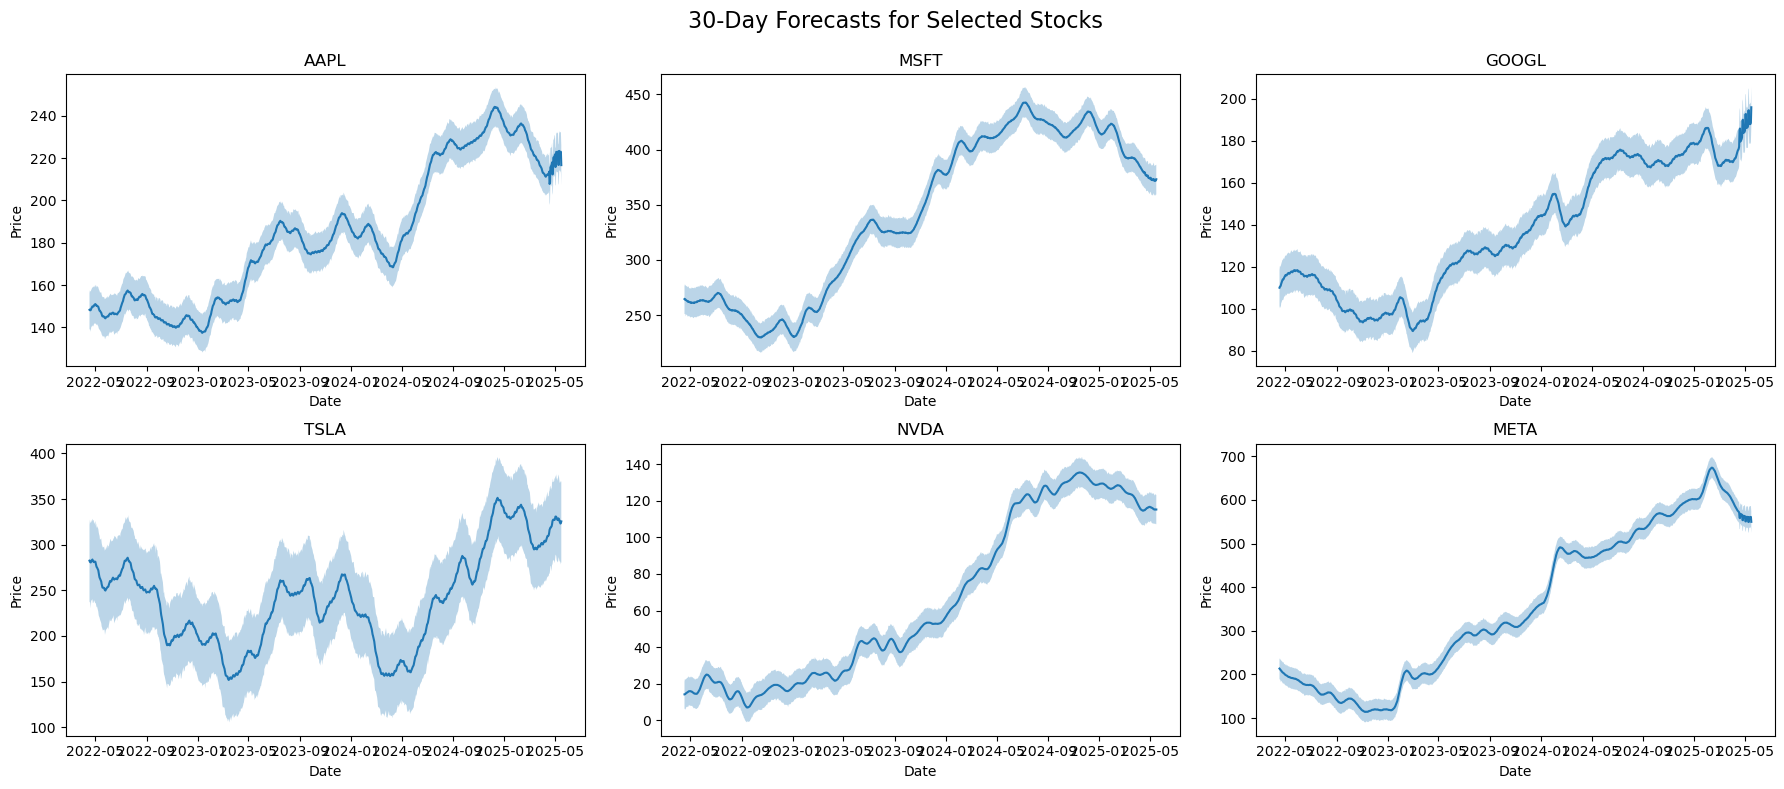

In [11]:
import matplotlib.pyplot as plt

# Filter valid results only
valid_results = [(symbol, forecast) for symbol, forecast in results if not isinstance(forecast, str)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=False)
axes = axes.flatten()

for ax, (symbol, forecast) in zip(axes, valid_results):
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
    ax.set_title(f"{symbol}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

fig.suptitle("30-Day Forecasts for Selected Stocks", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


In [12]:
import time

start_seq = time.time()
sequential_results = []
for symbol in tickers:
    sequential_results.append(run_forecast(symbol))
end_seq = time.time()

seq_time = end_seq - start_seq
print(f"Sequential runtime: {seq_time:.2f} seconds")


23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing
23:12:12 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing
23:12:12 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing
23:12:13 - cmdstanpy - INFO - Chain [1] start processing
23:12:13 - cmdstanpy - INFO - Chain [1] done processing


Sequential runtime: 2.72 seconds


In [13]:
start_par = time.time()
with ProcessPoolExecutor() as executor:
    parallel_results = list(executor.map(run_forecast, tickers))
end_par = time.time()

par_time = end_par - start_par
print(f"Parallel runtime: {par_time:.2f} seconds")


$MSFT: possibly delisted; no price data found  (period=3y)
$AAPL: possibly delisted; no price data found  (period=3y)
$NVDA: possibly delisted; no price data found  (period=3y)
$GOOGL: possibly delisted; no price data found  (period=3y)
$META: possibly delisted; no price data found  (period=3y)
$TSLA: possibly delisted; no price data found  (period=3y)


Parallel runtime: 2.76 seconds


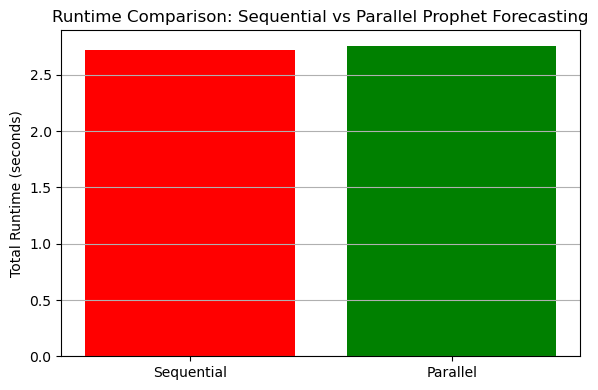

In [14]:
import matplotlib.pyplot as plt

labels = ['Sequential', 'Parallel']
times = [seq_time, par_time]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=['red', 'green'])
plt.ylabel('Total Runtime (seconds)')
plt.title('Runtime Comparison: Sequential vs Parallel Prophet Forecasting')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [15]:
df = yf.Ticker(symbol).history(period='10y').reset_index()


In [16]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META', 'AMZN', 'CRM', 'NFLX', 'BABA',
           'INTC', 'AMD', 'QCOM', 'CSCO', 'ORCL', 'UBER', 'LYFT', 'PYPL', 'SQ', 'SHOP']


In [18]:
import time

def run_forecast(symbol):
    time.sleep(1.5)
    return symbol, f"Done ({symbol})"


In [19]:
import time

start_seq = time.time()
sequential_results = []
for symbol in tickers:
    sequential_results.append(run_forecast(symbol))
end_seq = time.time()

seq_time = end_seq - start_seq
print(f"Sequential runtime: {seq_time:.2f} seconds")


Sequential runtime: 30.00 seconds


In [20]:
from concurrent.futures import ProcessPoolExecutor

start_par = time.time()
with ProcessPoolExecutor() as executor:
    parallel_results = list(executor.map(run_forecast, tickers))
end_par = time.time()

par_time = end_par - start_par
print(f"Parallel runtime: {par_time:.2f} seconds")


Parallel runtime: 4.62 seconds
